In [1]:
from utils import *
from MySolution import MyClassifier, MyClustering, MyLabelSelection

In [2]:
%load_ext autoreload
%autoreload 2

Synthetic data shape:  (1000, 2) (1000,)


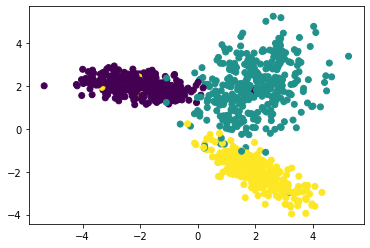

In [3]:
# Get datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])

MNIST data shape:  (1000, 784) (1000,)


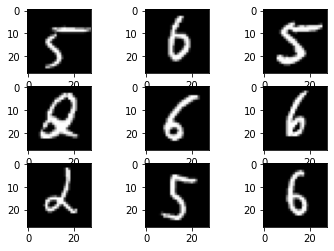

In [4]:
mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)

for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

In [5]:
syn_data["trainX"]

array([[ 2.45836059,  2.33615717],
       [ 3.0969569 , -3.06363196],
       [ 2.79162577,  2.89981478],
       ...,
       [ 1.51968087, -1.04721738],
       [-0.22859602,  1.71856747],
       [ 1.16551569,  0.85537577]])

In [6]:
classifier_syn = MyClassifier(K=len(set(syn_data["trainY"])),epsilon=-0.04)
classifier_mnist = MyClassifier(K=len(set(mnist_data["trainY"])),epsilon=0.09)

classifier_syn.train(syn_data)
classifier_mnist.train(mnist_data)

result1 = {
    'synthetic_test_accuracy':classifier_syn.evaluate(syn_data["testX"], syn_data["testY"]), 
    'mnist_test_accuracy':classifier_mnist.evaluate(mnist_data["testX"], mnist_data["testY"])
}

In [7]:
result1

{'synthetic_test_accuracy': 0.964, 'mnist_test_accuracy': 0.86}

In [26]:
result2 = {
    'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[], 'classification_accuracy':[]},
    'mnist':{'K':[3, 10, 32], 'clustering_nmi':[], 'classification_accuracy':[]}
}

In [27]:
syn_data["trainX"]+=4
syn_data["testX"]+=4
for K in result2["synthetic"]["K"]:
    cluster_syn = MyClustering(K)
    cluster_syn.train(syn_data["trainX"], maxiter=30)
    cluster_syn.align_labels(syn_data["trainY"])
    result2["synthetic"]['clustering_nmi'].append(cluster_syn.evaluate_clustering(syn_data["trainY"]))
    cluster_syn.align_labels(syn_data["trainY"])
    result2["synthetic"]['classification_accuracy'].append(
       cluster_syn.evaluate_classification(syn_data["testX"], syn_data["testY"])
    )
syn_data["trainX"]-=4
syn_data["testX"]-=4

train acc is:  0.955
train acc is:  0.953
train acc is:  0.972


In [28]:
# strongly recommend to first perform PCA to reduce the dimension
# sparse-NMF takes **very long** to solve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

std = StandardScaler()
pca = PCA(n_components=70)
trainX_std = std.fit_transform(mnist_data["trainX"])
testX_std = std.transform(mnist_data["testX"])
trainX_pca = pca.fit_transform(trainX_std)
testX_pca = pca.transform(testX_std)

# to feed into sparseNMF, we need to make our datapoints none-negative
nn = MinMaxScaler()
trainX_nn = nn.fit_transform(trainX_pca)
testX_nn = nn.transform(testX_pca)

In [29]:
for K in result2["mnist"]["K"]:
    cluster_mnist = MyClustering(K)
    cluster_mnist.train(trainX_nn)
    cluster_mnist.align_labels(mnist_data["trainY"])
    result2["mnist"]['clustering_nmi'].append(cluster_mnist.evaluate_clustering(mnist_data["trainY"]))
    result2["mnist"]['classification_accuracy'].append(
        cluster_mnist.evaluate_classification(testX_nn, mnist_data["testY"])
    )

train acc is:  0.526
train acc is:  0.937
train acc is:  0.922


In [30]:
result2

{'synthetic': {'K': [3, 5, 10],
  'clustering_nmi': [0.8278254854605318,
   0.8196789328405385,
   0.8730361307099103],
  'classification_accuracy': [0.678, 0.678, 0.912]},
 'mnist': {'K': [3, 10, 32],
  'clustering_nmi': [0.1642262217717552,
   0.7496071426679808,
   0.7191637713769791],
  'classification_accuracy': [0.588, 0.886, 0.914]}}

In [40]:
result3 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1], 'test_accuracy(our algo)':[], 'test_accuracy(random)':[]},
            'mnist': {'label_percentage':[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1], 'test_accuracy(our algo)':[], 'test_accuracy(random)':[]}}

In [41]:
for p in result3["synthetic"]["label_percentage"]:
    classifier = MyClassifier(K=len(set(syn_data["trainY"])),epsilon=-0.04)
    # selecter = MyLabelSelection(ratio=p)
    selecter = MyLabelSelection(ratio=p,theta=1.1)
    sel = selecter.select(syn_data["trainX"])
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(our algo)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))
    
    n, _ = syn_data["trainX"].shape
    sel = np.random.randint(0, n, size=int(n*p))
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(random)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))

In [42]:
for p in result3["mnist"]["label_percentage"]:
    classifier = MyClassifier(K=len(set(syn_data["trainY"])),epsilon=0.09)
    selecter = MyLabelSelection(ratio=p,theta=1.4)

    sel = selecter.select(mnist_data["trainX"])
    sel_data = {"trainX": mnist_data["trainX"][sel, :], "trainY": mnist_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["mnist"]["test_accuracy(our algo)"].append(classifier.evaluate(mnist_data["testX"], mnist_data["testY"]))
    
    n, _ = mnist_data["trainX"].shape
    sel = np.random.randint(0, n, size=int(n*p))
    sel_data = {"trainX": mnist_data["trainX"][sel, :], "trainY": mnist_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["mnist"]["test_accuracy(random)"].append(classifier.evaluate(mnist_data["testX"], mnist_data["testY"]))

In [43]:
result3

{'synthetic': {'label_percentage': [0.05,
   0.1,
   0.2,
   0.3,
   0.4,
   0.5,
   0.6,
   0.8,
   1],
  'test_accuracy(our algo)': [0.588,
   0.542,
   0.704,
   0.662,
   0.74,
   0.792,
   0.898,
   0.948,
   0.964],
  'test_accuracy(random)': [0.884,
   0.94,
   0.942,
   0.768,
   0.916,
   0.798,
   0.614,
   0.95,
   0.952]},
 'mnist': {'label_percentage': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1],
  'test_accuracy(our algo)': [0.41,
   0.544,
   0.708,
   0.762,
   0.816,
   0.842,
   0.85,
   0.856,
   0.86],
  'test_accuracy(random)': [0.58,
   0.674,
   0.732,
   0.768,
   0.796,
   0.814,
   0.8,
   0.812,
   0.846]}}

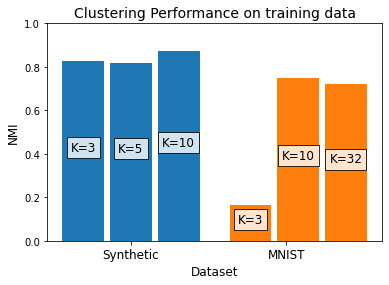

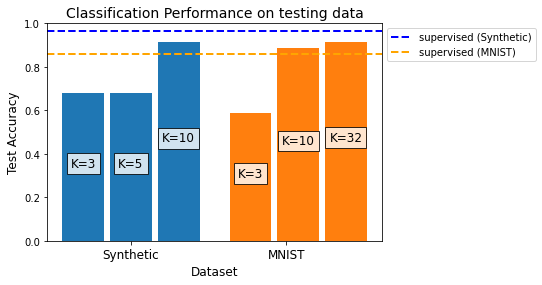

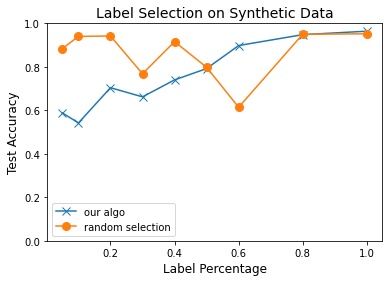

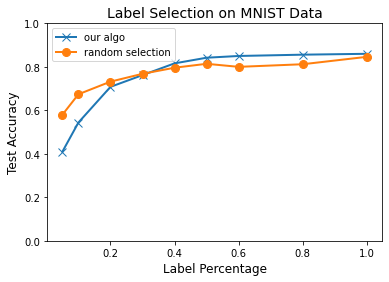

In [44]:
plot_result(result1, result2, result3)

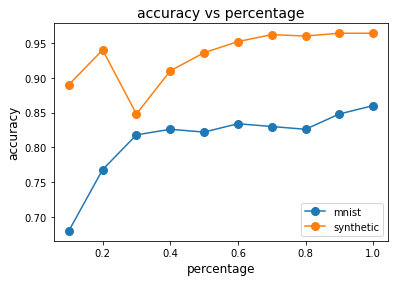

In [18]:
percentage = np.linspace(0.1, 1, 10)
acc_matrix = np.zeros((len(percentage), 2))
for i in range(0, len(percentage)):
    classifier = MyClassifier(3, epsilon=0.09)
    classifier.train(mnist_data, percentage=percentage[i])
    acc = classifier.evaluate(mnist_data['testX'], mnist_data['testY'])
    acc_matrix[i, 0] = acc

    classifier = MyClassifier(3, epsilon=-0.04)
    classifier.train(syn_data, percentage=percentage[i])
    acc = classifier.evaluate(syn_data['testX'], syn_data['testY'])
    acc_matrix[i, 1] = acc
plt.figure()
plt.plot(percentage, acc_matrix[:, 0], label='mnist', marker='o', markersize=8)
plt.plot(percentage, acc_matrix[:, 1], label='synthetic', marker='o', markersize=8)
plt.legend()
plt.xlabel('percentage', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.title('accuracy vs percentage', fontsize=14)
plt.show()

In [19]:
clustering_percentage = {
    "mnist": {
        "percentage": [.05, .2, .4, .6, .8, 1],
        "cluster_acc": [],
        "cluster_nmi": []
    }, 
    "synthetic": {
        "percentage": [.05, .2, .4, .6, .8, 1],
        "cluster_acc": [],
        "cluster_nmi": []
    }
}

In [20]:
for p in clustering_percentage["synthetic"]["percentage"]:
    n, _ = syn_data["trainX"].shape
    rand_id = np.random.randint(0, n, size=int(n*p))
    trainX = syn_data["trainX"][rand_id, :]
    trainY = syn_data["trainY"][rand_id]
    cluster_syn = MyClustering(5)
    cluster_syn.train(trainX, maxiter=30)
    cluster_syn.align_labels(trainY)
    clustering_percentage["synthetic"]['cluster_nmi'].append(cluster_syn.evaluate_clustering(trainY))
    clustering_percentage["synthetic"]['cluster_acc'].append(
       cluster_syn.evaluate_classification(syn_data["testX"], syn_data["testY"])
    )

train acc is:  0.92
train acc is:  0.885
train acc is:  0.8425
train acc is:  0.8533333333333334
train acc is:  0.8925
train acc is:  0.872


In [21]:
for p in clustering_percentage["mnist"]["percentage"]:
    n, _ = trainX_nn.shape
    rand_id = np.random.randint(0, n, size=int(n*p))
    trainX = trainX_nn[rand_id, :]
    trainY = mnist_data["trainY"][rand_id]
    cluster_syn = MyClustering(5)
    cluster_syn.train(trainX, maxiter=30)
    cluster_syn.align_labels(trainY)
    clustering_percentage["mnist"]['cluster_nmi'].append(cluster_syn.evaluate_clustering(trainY))
    clustering_percentage["mnist"]['cluster_acc'].append(
       cluster_syn.evaluate_classification(testX_nn, mnist_data["testY"])
    )

train acc is:  0.62
train acc is:  0.63
train acc is:  0.85
train acc is:  0.7916666666666666
train acc is:  0.75125
train acc is:  0.948


In [22]:
clustering_percentage

{'mnist': {'percentage': [0.05, 0.2, 0.4, 0.6, 0.8, 1],
  'cluster_acc': [0.564, 0.526, 0.848, 0.814, 0.778, 0.848],
  'cluster_nmi': [0.2221602909007087,
   0.2613657542508999,
   0.6097892094605086,
   0.4887851690835343,
   0.5224836023199084,
   0.7900619136828202]},
 'synthetic': {'percentage': [0.05, 0.2, 0.4, 0.6, 0.8, 1],
  'cluster_acc': [0.858, 0.882, 0.876, 0.896, 0.854, 0.858],
  'cluster_nmi': [0.7839067793896652,
   0.6811185597912989,
   0.6249892970331199,
   0.6439663876752186,
   0.7109279864701049,
   0.6732637514657818]}}

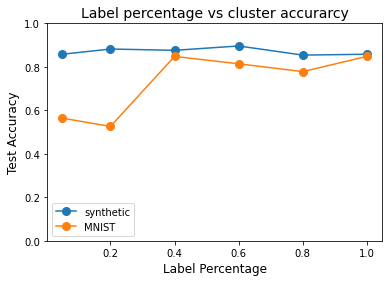

In [23]:
from matplotlib import pyplot as plt

plt.plot(clustering_percentage["synthetic"]['percentage'], clustering_percentage['synthetic']['cluster_acc'], label='synthetic', marker='o', markersize=8)
plt.plot(clustering_percentage["mnist"]['percentage'], clustering_percentage['mnist']['cluster_acc'], label='MNIST', marker='o', markersize=8)
plt.ylim(0,1)
plt.legend()
plt.xlabel("Label Percentage", fontsize=12) 
plt.ylabel('Test Accuracy', fontsize=12)
plt.title("Label percentage vs cluster accurarcy", fontsize=14)
plt.savefig("percentage.png", dpi=300)